# Financial Econometrics I: Homework 2
Jan Kubal & Matyáš Mattanelli

## Problem 1
### Loading data

In [2]:
#Loading necessary packages
suppressPackageStartupMessages({
library(quantmod)
})

In [3]:
#Loading the file containing the symbols
symbols2 <- read.csv("symbols2.csv")

#Generating 100 random numbers
set.seed(48983854) #random seed using the SIS number
indices <- sort(sample(1:377, 100, replace = F)) #geting sample, sorting from lowest to highest

#Extracting the tickers
tickers <- symbols2$Symbol[indices]

#Downloading the data for each ticker
tickers_data <- vector("list", length(tickers)) #Empty list for the data
options("getSymbols.warning4.0" = FALSE) #To suppress an annoying message
for (i in 1:length(tickers)) {
    tickers_data[[i]] <- getSymbols(tickers[i], src = "yahoo", auto.assign = F, from = "2019-01-01", to = "2022-01-01")
}

Warning message:
"BMS contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


In [4]:
#Check that the adjusted closing price is in the sixth column
sixth_cols <- vector("character", length(tickers_data))
is_adjusted <- vector("character", length(tickers_data))

for(i in 1:length(tickers_data)) {
 sixth_cols[i] <- names(tickers_data[[i]])[6]
}

for(i in 1:length(tickers_data)) {
 is_adjusted[i] <- substr(sixth_cols[i],  nchar(sixth_cols[i])-nchar("Adjusted")+1, nchar(sixth_cols[i])) #selecting only last eight characters of each column name
}

sum(is_adjusted == "Adjusted") #If we get here sum of 100, we got all the adjusted closing prices in the sixth column and can continue to subsetting

[1] 100

In [5]:
#Merging into a single xts object
adjusted_prices <- merge.xts(tickers_data[[1]][, 6], tickers_data[[2]][, 6]) #Initial merge
for (i in 3:100) { #Loop to merge all 100 tickers
    adjusted_prices <- merge.xts(adjusted_prices,tickers_data[[i]][, 6])
}

### 1) Log-returns

In [6]:
#Matyáš řešení
log_returns_M <- log(adjusted_prices) - log(lag(adjusted_prices))

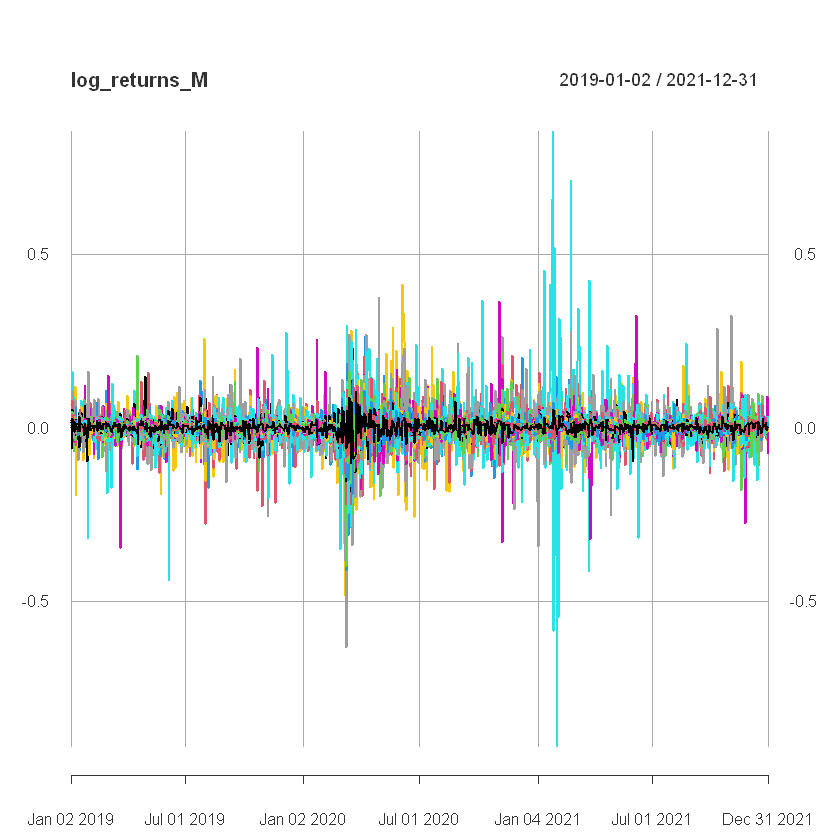

In [7]:
plot(log_returns_M)

In [8]:
#Creating list containing Log-returns
log_returns <- vector("list", length(tickers_data))

for(i in 1:length(tickers_data)) {
    obs <- length(tickers_data[[i]][,6])
    lrets <- vector("numeric", obs)
    lrets[1] <- NA

    for(n in 2:obs){
        lrets[n] <- as.numeric(log(tickers_data[[i]][n,6])) - as.numeric(log(tickers_data[[i]][n-1,6]))
    }

    log_returns[[i]] <- data.frame(Date = index(tickers_data[[i]]), tickers_data[[i]][,6], Log_returns = lrets)
}

#Each element of the list log_returns is a dataframe, containing dates, original closing prices and logarithmic returns
#(the original prices is included mainly so the firm it belongs to could be easily recognized by ticker)

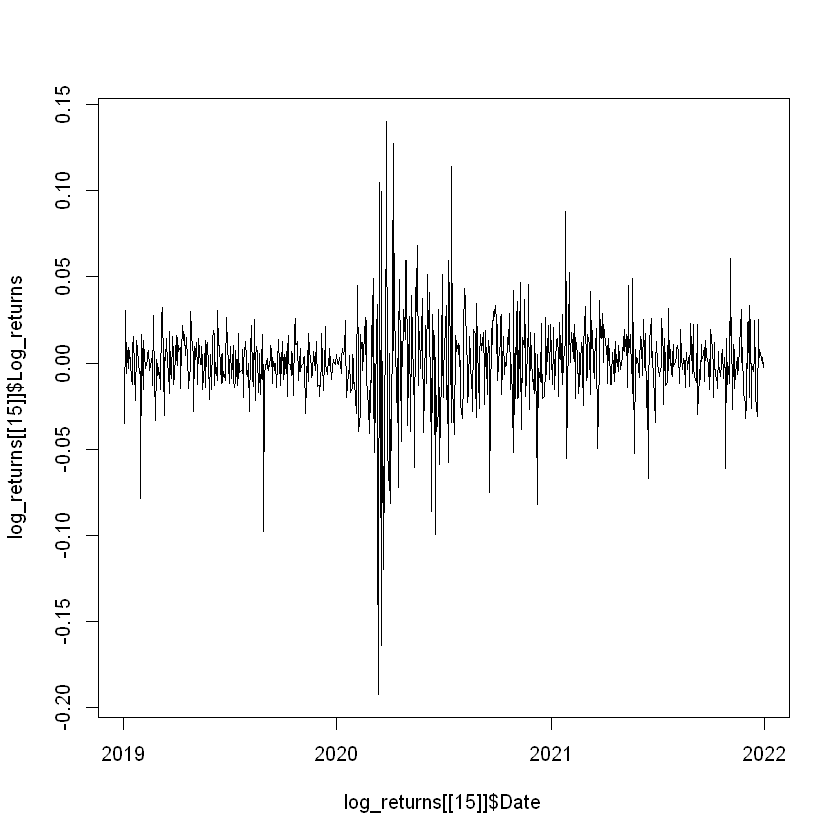

In [9]:
plot(x=log_returns[[15]]$Date, y=log_returns[[15]]$Log_returns, type="l")

In [10]:
#Just some notes

#plot ACF and PACF of logrets? or logrets^2?
#lagrange multiplier test for ARCH effect? (arch.test)?
#alpha - effetc of past excess return (ret. different from mean), beta - effect of variance (volatility) from the previous period

### 2) Estimating GARCH(1,1) models

In [11]:
library(rugarch)

Warning message:
"package 'rugarch' was built under R version 4.1.3"
Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma




In [12]:
#Estimating GARCH(1,1) models and saving fitted objects in list
garch_list <- vector("list", length(tickers_data))

for(i in 1:length(tickers_data)){
    garch_spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0)), variance.model = list(garchOrder = c(1, 1)))
    garch_fit <- ugarchfit(garch_spec, na.omit(log_returns[[i]]$Log_returns),solver="hybrid") #solver="hybrid" to ensure convergence

    garch_list[[i]] <- garch_fit
}

### 3) Extracting and plotting alphas and betas

In [13]:
coef_df <- data.frame(Firm = tickers, 
                    alphas = rep(NA, length(tickers_data)), 
                    betas = rep(NA, length(tickers_data)), 
                    ab_sum = rep(NA, length(tickers_data)))

In [14]:
for(i in 1:length(tickers_data)){
    coef_df$alphas[i] <- as.numeric(coef(garch_list[[i]])[3])
    coef_df$betas[i] <- as.numeric(coef(garch_list[[i]])[4])
    coef_df$ab_sum[i] <- as.numeric(coef(garch_list[[i]])[3]) + as.numeric(coef(garch_list[[i]])[4])
}

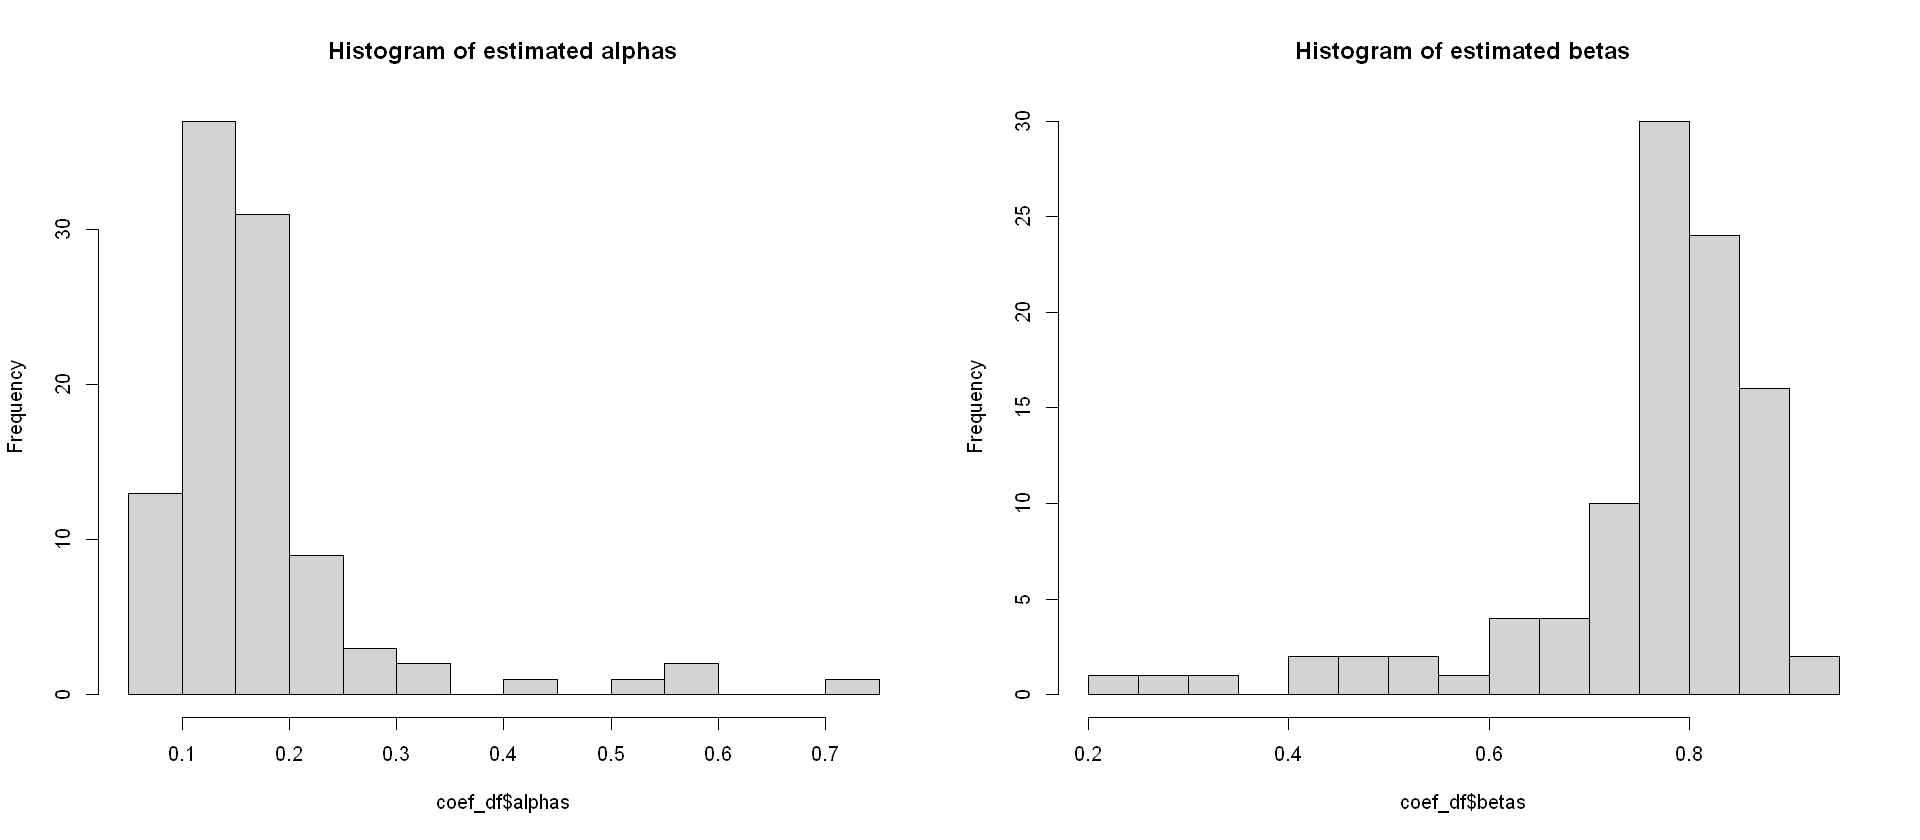

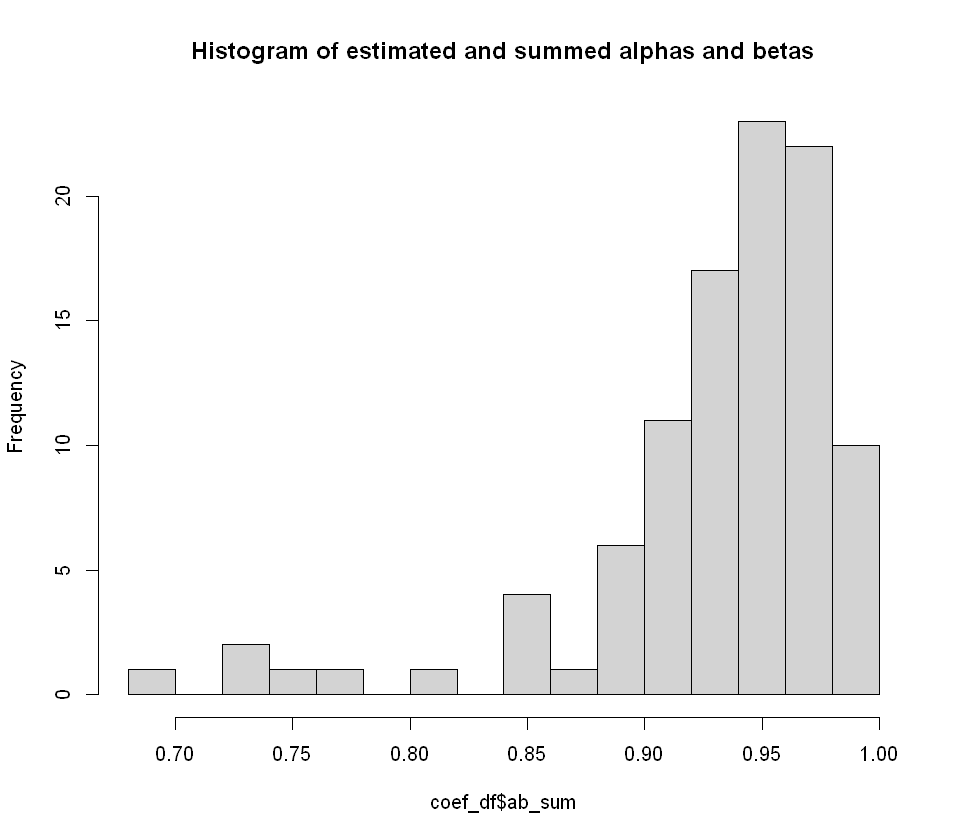

In [15]:
#ploting the crossection of coefficients
options(repr.plot.width = 16, repr.plot.height = 7)
par(mfrow = c(1, 2))
hist(coef_df$alphas, breaks = 10, main = "Histogram of estimated alphas")
hist(coef_df$betas, breaks = 10, main = "Histogram of estimated betas")
options(repr.plot.width = 8, repr.plot.height = 7)
par(mfrow = c(1, 1))
hist(coef_df$ab_sum, breaks = 11, main = "Histogram of estimated and summed alphas and betas")

### 4) Maximum estimated coefficients

In [16]:
#alpha
m_a <- max(coef_df$alphas)
m_a_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_a, coef_df$alphas)]]

#beta
m_b <- max(coef_df$betas)
m_b_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_b, coef_df$betas)]]

#sums
m_ab <- max(coef_df$ab_sum)
m_ab_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_ab, coef_df$ab_sum)]]

print(paste("Maximum estimated alpha:", m_a, "for firm", m_a_name))
print(paste("Maximum estimated beta:", m_b, "for firm", m_b_name))
print(paste("Maximum estimated sum:", m_ab, "for firm", m_ab_name))

[1] "Maximum estimated alpha: 0.730022572796107 for firm Hasbro Inc."
[1] "Maximum estimated beta: 0.916040480610233 for firm Ryder System"
[1] "Maximum estimated sum: 0.998999981740827 for firm Host Hotels & Resorts"


### 5) Estimated volatility averaged 

In [17]:
#Extracting the volatilities
volatilities <- vector("list", length(garch_list))
for (iter in 1:length(garch_list)) {
    vol <- rep(NA, length(index(na.omit(tickers_data[[iter]]))))
    vol[2:length(vol)] <- as.numeric(sigma(garch_list[[iter]]))
    volatilities[[iter]] <- data.frame(Date=index(na.omit(tickers_data[[iter]])),Volatility=vol)
}

In [59]:
#Computing the quantiles
days <- seq(from = as.Date("2019-01-01"), to = as.Date("2021-12-31"), by="day")
five_percent <- rep(NA, length(days))
medians <- rep(NA, length(days))
ninety_five_percent <- rep(NA, length(days))
for (iter_day in 1:length(days)) { #For each day
    daily_vol <- rep(NA, 100) #Empty vector for daily volatilities accross tickers
    for (iter_ticker in 1:100) { #For each ticker check if the value exists
        if (days[iter_day] %in% volatilities[[iter_ticker]]$Date) {
            #daily_vol[iter_ticker] <- volatilities[[iter_ticker]]$Volatility[iter_day] #corecting bug that was on this line (subseting vector of length 757 by numbers 757+)
            daily_vol[iter_ticker] <- volatilities[[iter_ticker]]$Volatility[volatilities[[iter_ticker]]$Date == days[iter_day]]
    } else {
        daily_vol[iter_ticker] <- NA
    }
    }
    five_percent[iter_day] <- quantile(daily_vol, probs = 0.05, na.rm = TRUE)
    medians[iter_day] <- quantile(daily_vol, probs = 0.5, na.rm = TRUE)
    ninety_five_percent[iter_day] <- quantile(daily_vol, probs = 0.95, na.rm = TRUE)
    #print(summary(daily_vol))
}

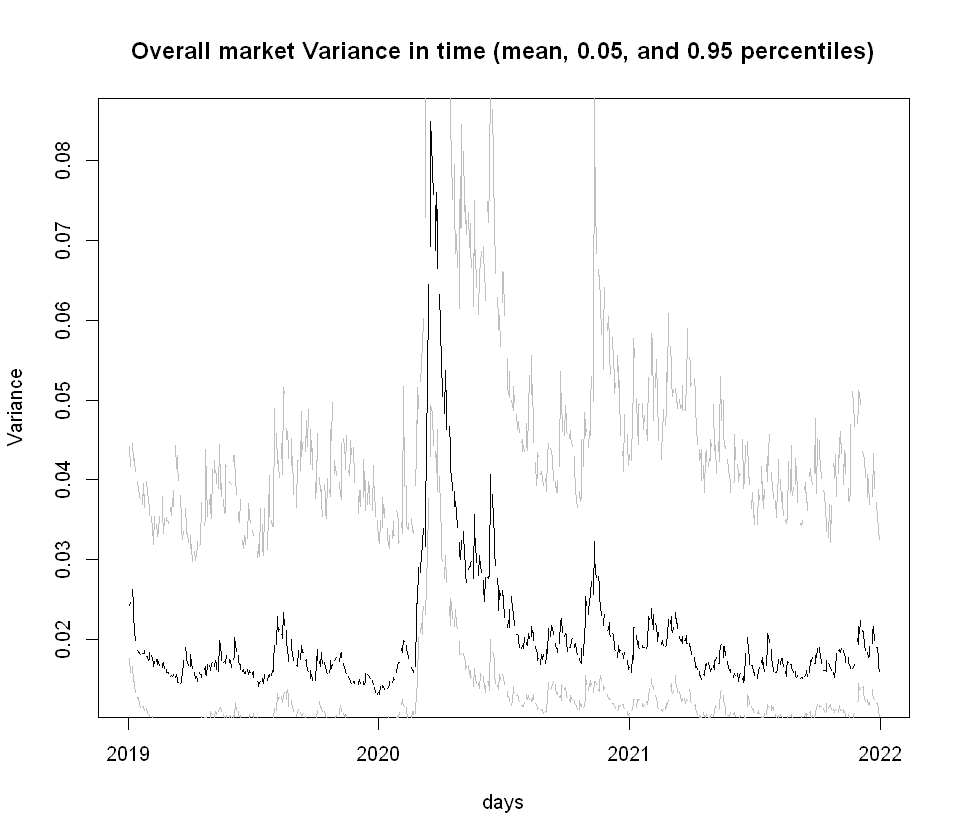

In [66]:
plot(x = days, y = medians, type = "l", main = "Overall market Variance in time (mean, 0.05, and 0.95 percentiles)", ylab="Variance")

lines(x = days, y = five_percent, type = "l", col = "grey")
lines(x = days, y = ninety_five_percent, type = "l", col = "grey")

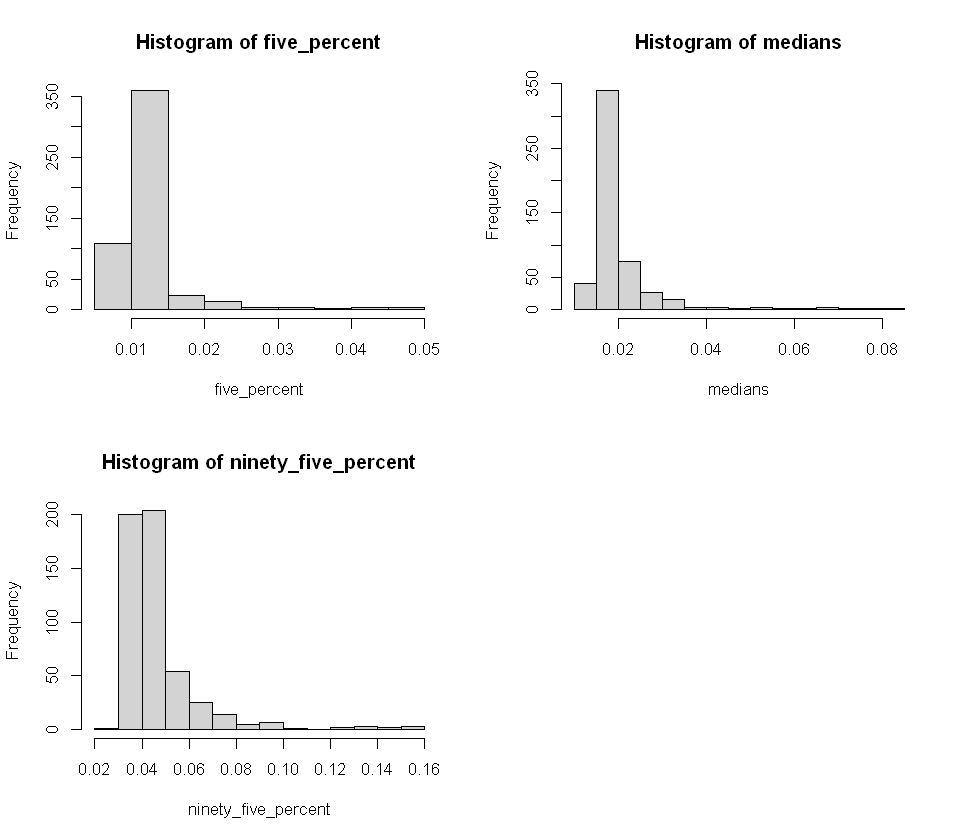

In [19]:
par(mfrow=c(2,2))
hist(five_percent)
hist(medians)
hist(ninety_five_percent)

### Problem 2

In [20]:
#Computing the means
log_returns_means <- apply.daily(log_returns_M, function(x) mean(c(x))) 

In [21]:
log_returns_means

                    [,1]
2019-01-02            NA
2019-01-03 -0.0161113595
2019-01-04  0.0330878993
2019-01-07  0.0094452929
2019-01-08  0.0088163236
2019-01-09  0.0113590025
2019-01-10  0.0034898330
2019-01-11 -0.0011711845
2019-01-14 -0.0060516376
2019-01-15  0.0047427698
2019-01-16  0.0021419241
2019-01-17  0.0089915092
2019-01-18  0.0138977658
2019-01-22 -0.0168472177
2019-01-23 -0.0001059497
2019-01-24  0.0067531130
2019-01-25  0.0125296876
2019-01-28 -0.0061280455
2019-01-29 -0.0012260905
2019-01-30  0.0106549627
2019-01-31  0.0057136382
2019-02-01  0.0035659577
2019-02-04  0.0063614423
2019-02-05  0.0037370196
2019-02-06 -0.0010642861
2019-02-07 -0.0094575650
2019-02-08 -0.0028909888
2019-02-11  0.0038323543
2019-02-12  0.0142803243
2019-02-13  0.0041937544
2019-02-14 -0.0014445099
2019-02-15  0.0112987305
2019-02-19  0.0016466172
2019-02-20  0.0046962202
2019-02-21 -0.0063651058
2019-02-22  0.0058719116
2019-02-25 -0.0007003442
2019-02-26 -0.0018951790
2019-02-27  0.0005613444
